In [1]:
from torchvision import transforms
import torch
import predictionLibs as pl
import pathlib as pt
import matplotlib.pyplot as plt
from functools import partial
import sys
import scipy.io as scio

The most simple training practice in machine learning is a simple train test split. We will divide our data into two sets, one set with 7 training examples and a final set which contains our last test examlple.

In [2]:
data_folder = pt.Path("torch_files")
data_files = list(data_folder.glob("*"))
# simple train test split
train_files = data_files[:-1]
test_files = data_files[-1:]
print(train_files)
print(test_files)

[WindowsPath('torch_files/wall_h20_l48'), WindowsPath('torch_files/wall_h40_l24'), WindowsPath('torch_files/wall_h60_l12'), WindowsPath('torch_files/wall_h60_l16'), WindowsPath('torch_files/wall_h60_l24'), WindowsPath('torch_files/wall_h60_l32'), WindowsPath('torch_files/wall_h60_l8')]
[WindowsPath('torch_files/wall_h80_l12')]


In [3]:
# create the datsets and loaders
train_dataset = pl.WSSDataset(train_files, transform=transforms.Compose([pl.RandomRotate(541)]))
test_dataset = pl.WSSDataset(test_files)

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=1)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=1)

In [4]:
# create the model, loss function and optimizer
model = pl.UNet(3, 1)
criteria = torch.nn.L1Loss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# create a resizing function, lets us make the images smaller to speed up the learning, however, the input for the CNN must also be even
resizer = partial(torch.nn.functional.interpolate, align_corners=True, 
    mode="bilinear", size=(256, 512))

# heres where the magic happens, lets convert our model to a GPU model
model.to("cuda:0")
n_epochs = 50
for epoch in range(n_epochs):
    for i, data in enumerate(train_loader):
        x, y = data.values()
        x = resizer(x).float()
        # scale the input data by 1000000 to avoid floating point issues and obtain 
        # more stable solutions
        y = resizer(y).float()*1000000
        # convert our tensors to cuda tensors and scale the data to avoid floating 
        # point errors
        x = x.cuda()
        y = y.cuda()

        y_pred = model(x)
        loss = criteria(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # lets keep track of our loss, as long as its going down we're all good
    sys.stdout.write("\r Cycle %d, current loss: %0.3f"%(
        cycle, loss.cpu().detach().numpy()))
    sys.stdout.flush()


 Cycle 49, current loss: 1.712

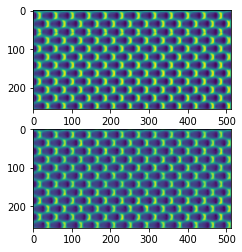

In [5]:
# now plot our prediction for the current training example
f, ax = plt.subplots(2,1)

# plot the prediction
ax[0].imshow(y_pred[0][0].cpu().detach().numpy())
# plot the ground truth
ax[1].imshow(y[0][0].cpu().detach().numpy())
plt.show()

Finally we can plot the results of the testing set

current loss: 2.620

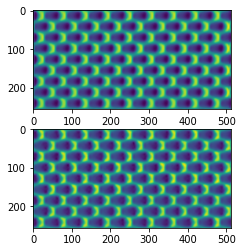

In [6]:

with torch.no_grad():
    for i, data in enumerate(test_loader):
        x, y_orig = data.values()
        x = resizer(x).float()
        # scale the input data by 1000000 to avoid floating point issues and obtain 
        # more stable solutions
        y = resizer(y_orig).float()*1000000
        # convert our tensors to cuda tensors and scale the data to avoid floating 
        # point error
        x = x.cuda()
        y = y.cuda()
        y_pred = model(x)
        loss = criteria(y_pred, y)
        sys.stdout.write("current loss: %0.3f"%(loss.cpu().detach().numpy()))

# now plot our prediction for the single testing example
f, ax = plt.subplots(2,1)
# plot the prediction
ax[0].imshow(y_pred[0][0].cpu().detach().numpy())
# plot the ground truth
ax[1].imshow(y[0][0].cpu().detach().numpy())
plt.show()

In [7]:
# resize the data to the original size and unscale
upsizer = partial(torch.nn.functional.interpolate, align_corners=True, 
    mode="bilinear", size=(541, 864))
y_pred_upsized = upsizer(y_pred)/1000000
# save the dat to a mat file
output = {
    "y_pred": y_pred_upsized.cpu().detach().numpy(),
    "y_true": y_orig.cpu().detach().numpy()
}

scio.savemat("pred_vs_truth.mat", output)


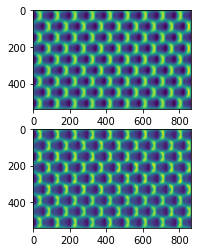

In [8]:

f, ax = plt.subplots(2,1)
ax[0].imshow(output["y_pred"][0][0])
# plot the ground truth
ax[1].imshow(output["y_true"][0][0])
plt.show()